# *20-08-2021*
# Complete Data Pre-processing 
### This is where i do complete data preprocessing
- Uniformise plane of reference
- Remove blanks
- Quantile filtering
- Crop
- Spline Interpolated Zoom
- Normalize

#### UNIFORMISE PLANE OF REFERENCE
https://www.kaggle.com/boojum/connecting-voxel-spaces

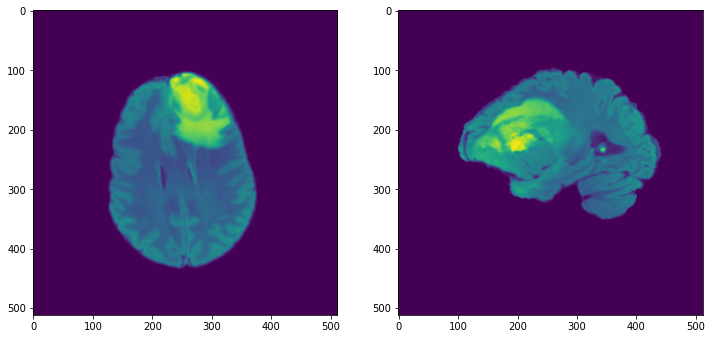

In [1]:
import glob
import pydicom
import matplotlib.pyplot as plt
import numpy as np

patient = '00006'
patient2 = '00002'
# load patient slices
sorted_imgs = sorted(glob.glob('./datasets/kaggle-brain-tumor/train/'+patient+'/FLAIR/*.dcm'))
slices = [pydicom.read_file(s) for s in sorted_imgs]
slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
images = np.stack([s.pixel_array for s in slices])
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(images[80])

sorted_imgs2 = sorted(glob.glob('./datasets/kaggle-brain-tumor/train/'+patient2+'/FLAIR/*.dcm'))
slices2 = [pydicom.read_file(s) for s in sorted_imgs2]
slices2.sort(key = lambda x: float(x.ImagePositionPatient[2]))
images2 = np.stack([s.pixel_array for s in slices2])
plt.subplot(122)
plt.imshow(images2[50])

In [48]:
import nibabel as nib
import SimpleITK as sitk

def resample(image, ref_image):

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(ref_image)
    resampler.SetInterpolator(sitk.sitkLinear)
    
    resampler.SetTransform(sitk.AffineTransform(image.GetDimension()))

    resampler.SetOutputSpacing(ref_image.GetSpacing())
    
    resampler.SetSize(ref_image.GetSize())
    #resampler.SetSize(image.GetSize())
    
    
    resampler.SetOutputDirection(ref_image.GetDirection())

    resampler.SetOutputOrigin(ref_image.GetOrigin())

    resampler.SetDefaultPixelValue(image.GetPixelIDValue())

    resamped_image = resampler.Execute(image)
    
    return resamped_image

#flair_resampled = resample(flair_sitk, t1_sitk)
#t1_sitk_array = sitk.GetArrayFromImage(t1_sitk)
#flair_resampled_array = sitk.GetArrayFromImage(flair_resampled)


In [3]:
reader = sitk.ImageSeriesReader()
reader.LoadPrivateTagsOn()

In [4]:
# load reference itk (i.e. 00002)
filenamesDICOM = reader.GetGDCMSeriesFileNames('./datasets/kaggle-brain-tumor/train/'+patient+'/FLAIR')
reader.SetFileNames(filenamesDICOM)
t1_sitk = reader.Execute()

In [5]:
filenamesDICOM = reader.GetGDCMSeriesFileNames('./datasets/kaggle-brain-tumor/train/'+patient2+'/FLAIR')
reader.SetFileNames(filenamesDICOM)
flair_sitk = reader.Execute()

In [6]:
flair_resampled = resample(flair_sitk, t1_sitk)

In [7]:
t1_sitk_array = sitk.GetArrayFromImage(t1_sitk)
flair_resampled_array = sitk.GetArrayFromImage(flair_resampled)

64


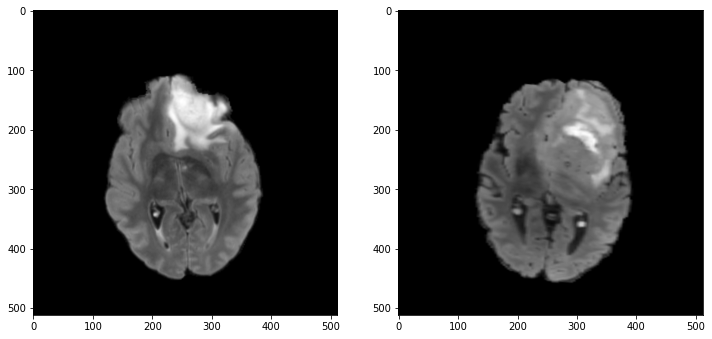

In [8]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(t1_sitk_array[t1_sitk_array.shape[0]//2,:,:], cmap='gray')
plt.subplot(122)
plt.imshow(flair_resampled_array[flair_resampled_array.shape[0]//2,:,:], cmap='gray')
print(flair_resampled_array.shape[0]//2)

In [104]:
np.unique(flair_resampled_array[1])

array([0, 2], dtype=int16)

In [94]:
import os
import math

patients = os.listdir('./datasets/kaggle-brain-tumor/train')

# reference FLAIR
filenamesDICOM = reader.GetGDCMSeriesFileNames('./datasets/kaggle-brain-tumor/train/'+'00006'+'/FLAIR')
reader.SetFileNames(filenamesDICOM)
reference_flair = reader.Execute()

for patient in patients[:10]:
    # NOTE resampling also resamples the depth
    filenamesDICOM = reader.GetGDCMSeriesFileNames('./datasets/kaggle-brain-tumor/train/'+patient+'/FLAIR')
    reader.SetFileNames(filenamesDICOM)
    patient_stik = reader.Execute()
    patient_resampled = resample(patient_stik, reference_flair)
    resampled_images = sitk.GetArrayFromImage(patient_resampled)
    # preprocessing steps
    pre_cleaned = resampled_images
    images = clean_images(resampled_images)
    images = quantile_filtering(images)
    images = normalize(images)
    print(images.shape[0])

ImageSeriesReader (0x562166ada060): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000398747



44
40
42


ImageSeriesReader (0x562166ada060): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000754849



42
41


ImageSeriesReader (0x562166ada060): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000103474



40


ImageSeriesReader (0x562166ada060): Non uniform sampling or missing slices detected,  maximum nonuniformity:9.14411e-05



39
42


ImageSeriesReader (0x562166ada060): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000662598



42


ImageSeriesReader (0x562166ada060): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.0003



39


In [90]:
images.shape

(45, 512, 512)

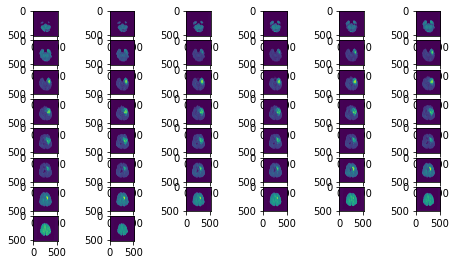

In [85]:

w = 15
h = 15
fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 15
for i in range(1, images.shape[0]):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i])
plt.show()

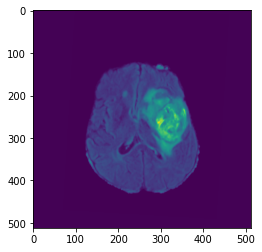

In [86]:
plt.imshow(images[25])

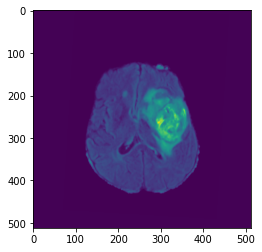

In [87]:
plt.imshow(images[25])

In [93]:
def clean_images(resampled_images):
    '''
    A function to remove blanks and images with only two pixel values (cause of resampling)
    '''
    #print(f'Cleaning original: {resampled_images.shape}')
    cleaned = []
    for i in range(resampled_images.shape[0]):
        img_q = resampled_images[i]
        if np.min(img_q) == np.max(img_q) or len(np.unique(img_q)) == 2:
            continue
        else:
            cleaned.append(img_q)
    cleaned = np.array(cleaned)
    #print(f'Cleaned: {cleaned.shape}')
    return cleaned

def quantile_filtering(images, lower=0.20, upper=0.80):
    '''
    Filter images in the required quantile
    '''
    # selective filtering
    #print(images.shape)
    num_images = images.shape[0]
    #print(images.shape)
    lb = math.floor(lower*num_images)
    ub = math.floor(upper*num_images)
    images = images[lb:ub]
    #print(images.shape)
    return images

def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

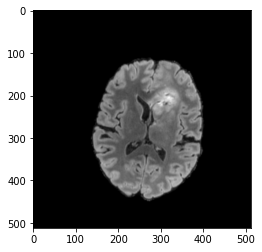

In [54]:
plt.imshow(images[25], cmap='gray')

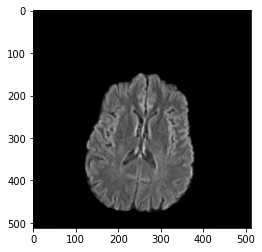

In [63]:
plt.imshow(images[29], cmap='gray')

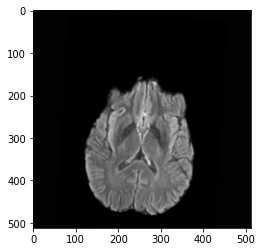

In [61]:
plt.imshow(images[25], cmap='gray')